In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import DivergingNorm
import sys
sys.path.insert(1, '../../utils/')
import src_utils
import seaborn as sns

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import scipy

# 1. Set rcParams

In [2]:
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rcParams['axes.linewidth'] = 0.5

plt.rcParams["figure.dpi"] = 300

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=MEDIUM_SIZE)  # fontsize of the figure title

# 2. Set up grid

"f3_ax1.set_title('gs[0, 0]')\nf3_ax2.set_title('gs[0, 1]')\nf3_ax3.set_title('gs[1:, 0]')\nf3_ax4.set_title('gs[1, 1]')\nf3_ax5.set_title('gs[2, 0]')\nf3_ax6.set_title('gs[2, 1]')\nf3_ax7.set_title('gs[:, 2]')"

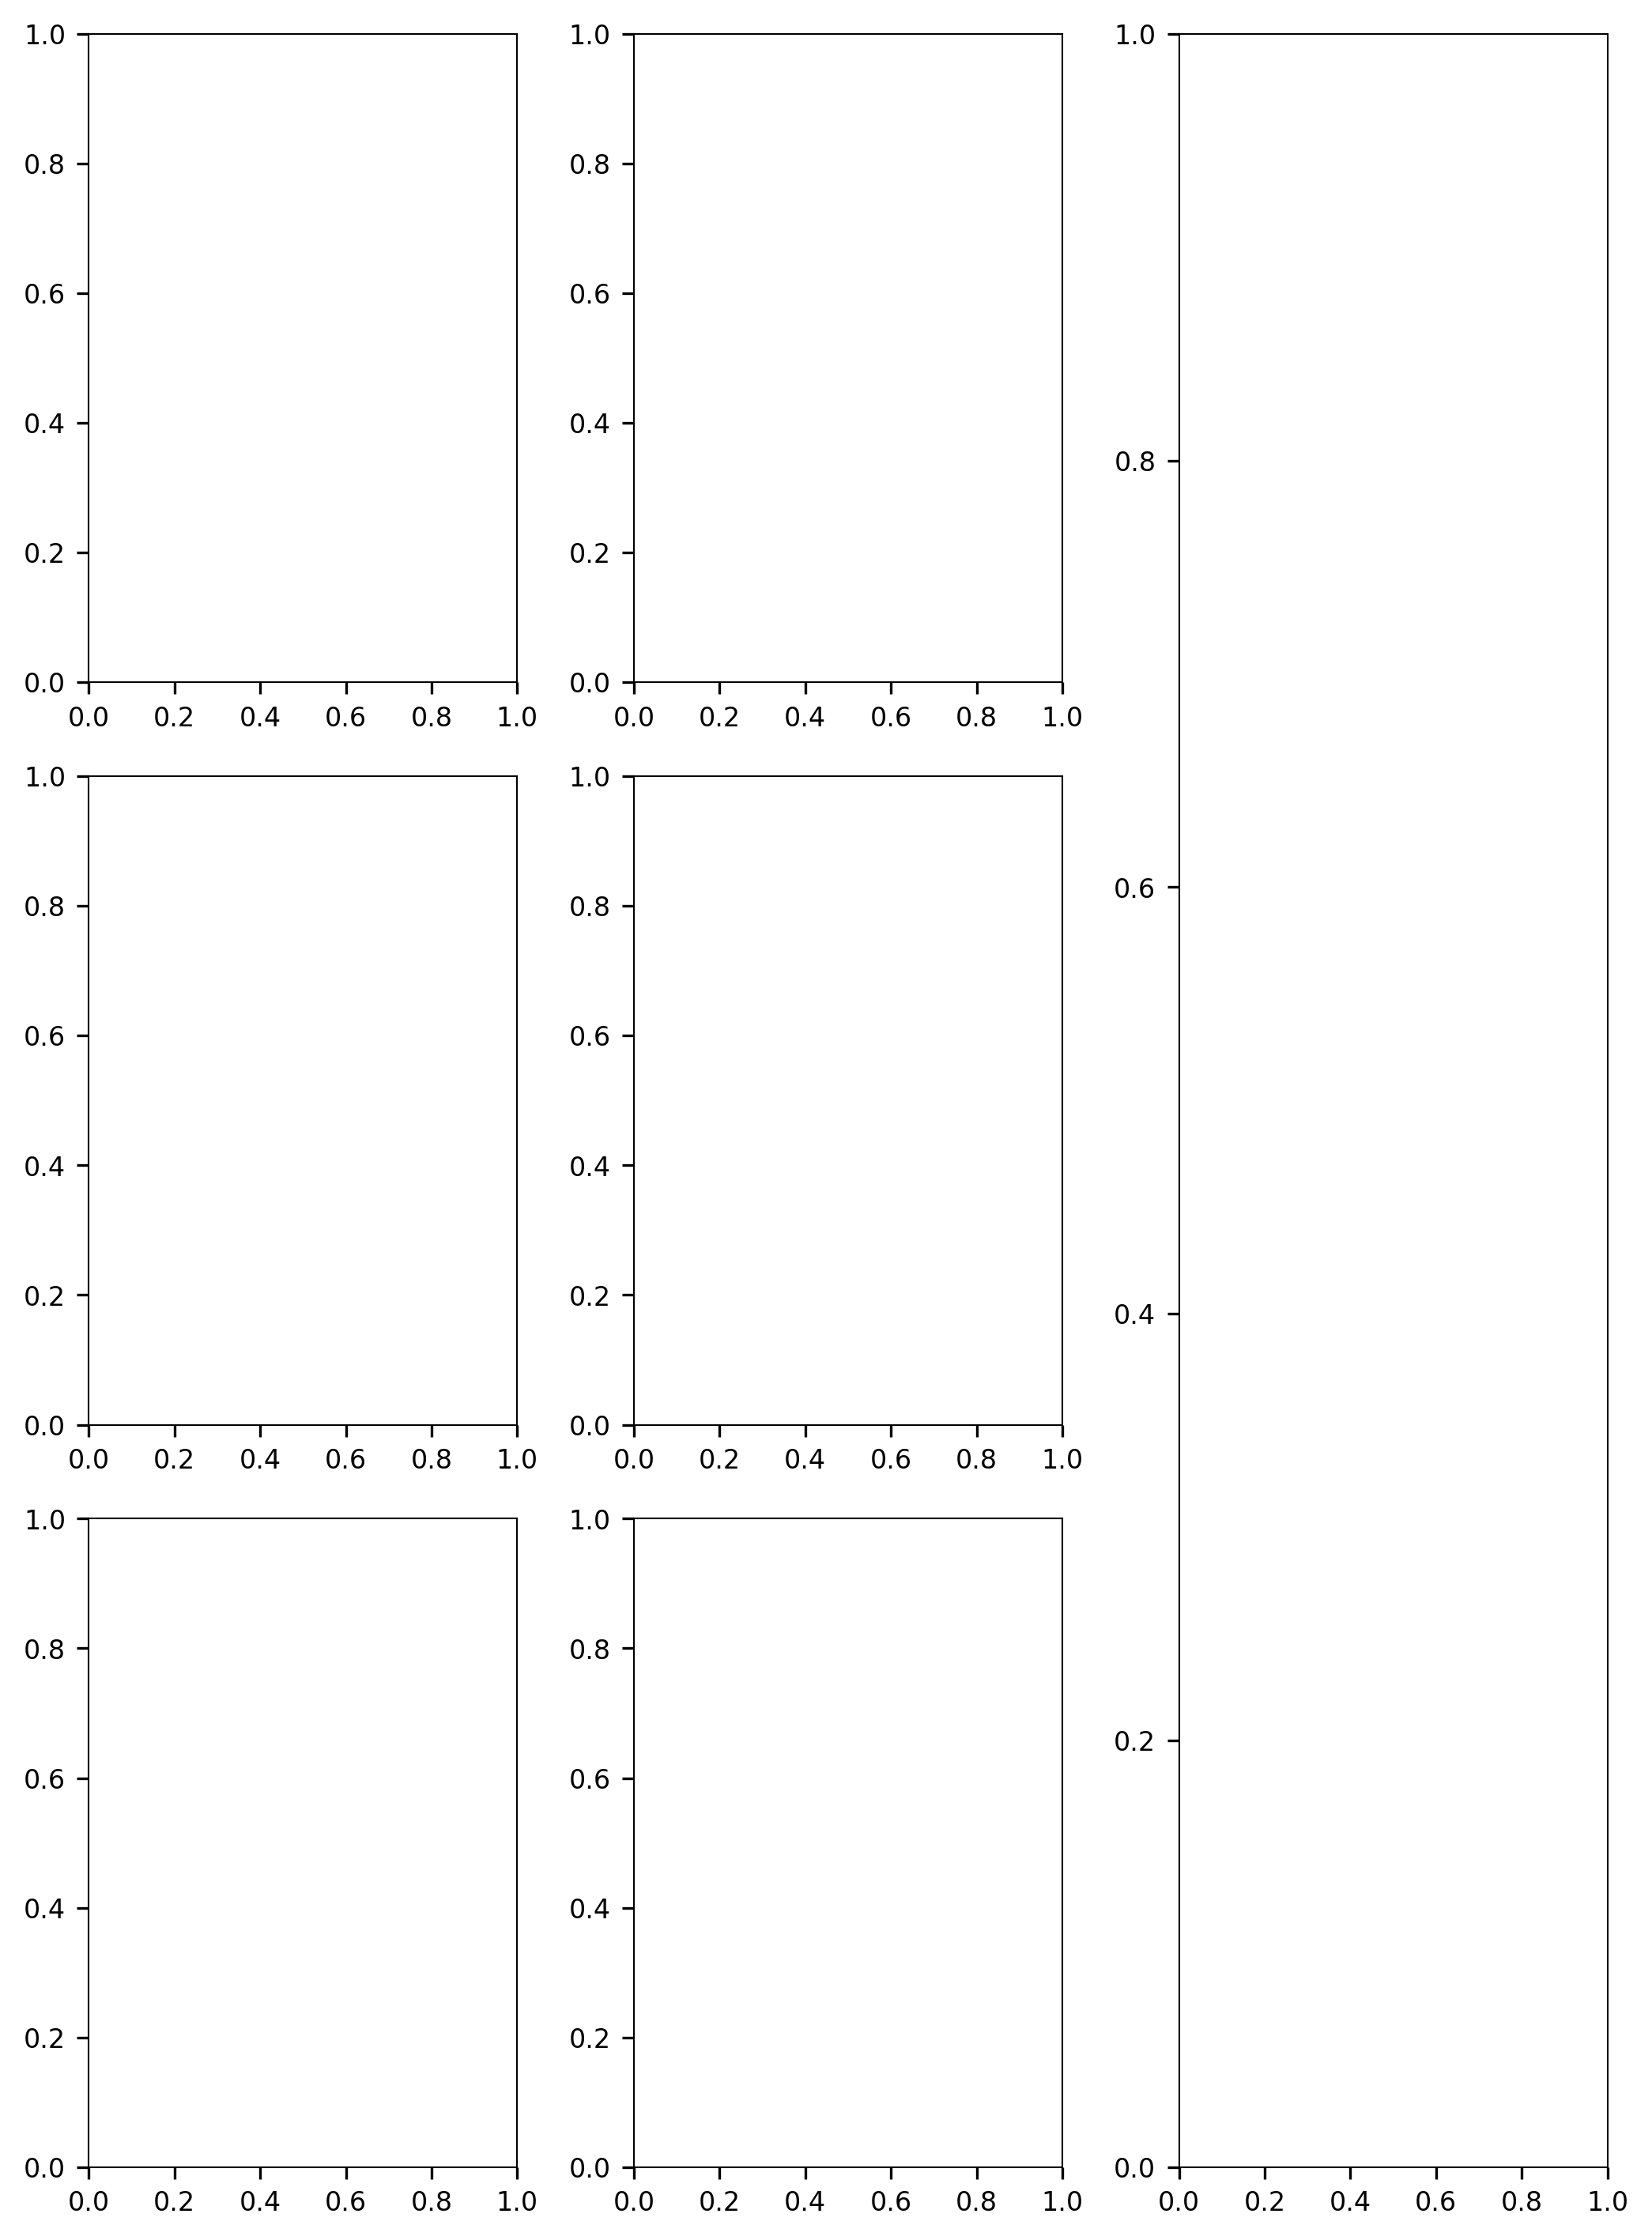

In [3]:
width = 174 / 25.4
height = 237 / 25.4
fig3 = plt.figure(constrained_layout=True, figsize=(width, height))
gs = fig3.add_gridspec(3, 3)
f3_ax1 = fig3.add_subplot(gs[0, 0])
f3_ax2 = fig3.add_subplot(gs[0, 1])
f3_ax3 = fig3.add_subplot(gs[1, 0])
f3_ax4 = fig3.add_subplot(gs[1, 1])
f3_ax5 = fig3.add_subplot(gs[2, 0])
f3_ax6 = fig3.add_subplot(gs[2, 1])
f3_ax7 = fig3.add_subplot(gs[:, 2])

"""f3_ax1.set_title('gs[0, 0]')
f3_ax2.set_title('gs[0, 1]')
f3_ax3.set_title('gs[1:, 0]')
f3_ax4.set_title('gs[1, 1]')
f3_ax5.set_title('gs[2, 0]')
f3_ax6.set_title('gs[2, 1]')
f3_ax7.set_title('gs[:, 2]')"""


# A. Replicate correlation

In [5]:
# Create a store of h5 file
raw_data = pd.HDFStore('../../raw_data/2017.07.24_Radicicol_exp.h5')
raw_data_keys = raw_data.keys()

# ONLY USE RADICICOL SCORES FOR REP1 and REP2
variant_scores = raw_data.select('/main/synonymous/scores_shared')
rep1 = -1 * np.concatenate(
    (
        variant_scores.loc[:, ('Radicicol', 'Rad1', 'score')].values,
        #variant_scores.loc[:, ('Zero', 'Zero1', 'score')].values
    )
)
rep2 = -1 * np.concatenate(
    (
        variant_scores.loc[:, ('Radicicol', 'Rad2', 'score')].values,
        #variant_scores.loc[:, ('Zero', 'Zero2', 'score')].values
    )
)

# Combine replicates into a dataframe to drop variants with NaNs
rep_df = pd.DataFrame([rep1, rep2]).T
rep_df.dropna(inplace=True)

# Plot on grid
f3_ax1.scatter(rep_df[0], rep_df[1], c='k')

# Calculate correlation coefficient using scipy and plot on graph
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(rep_df[0], rep_df[1])
f3_ax1.text(-3, 6, '$r$ = %0.2f' % r_value)

# Set axes labels
f3_ax1.set_xlabel('Rep1 activity score')
f3_ax1.set_ylabel('Rep2 activity score')

Text(13.333333333333332, 0.5, 'Rep2 activity score')

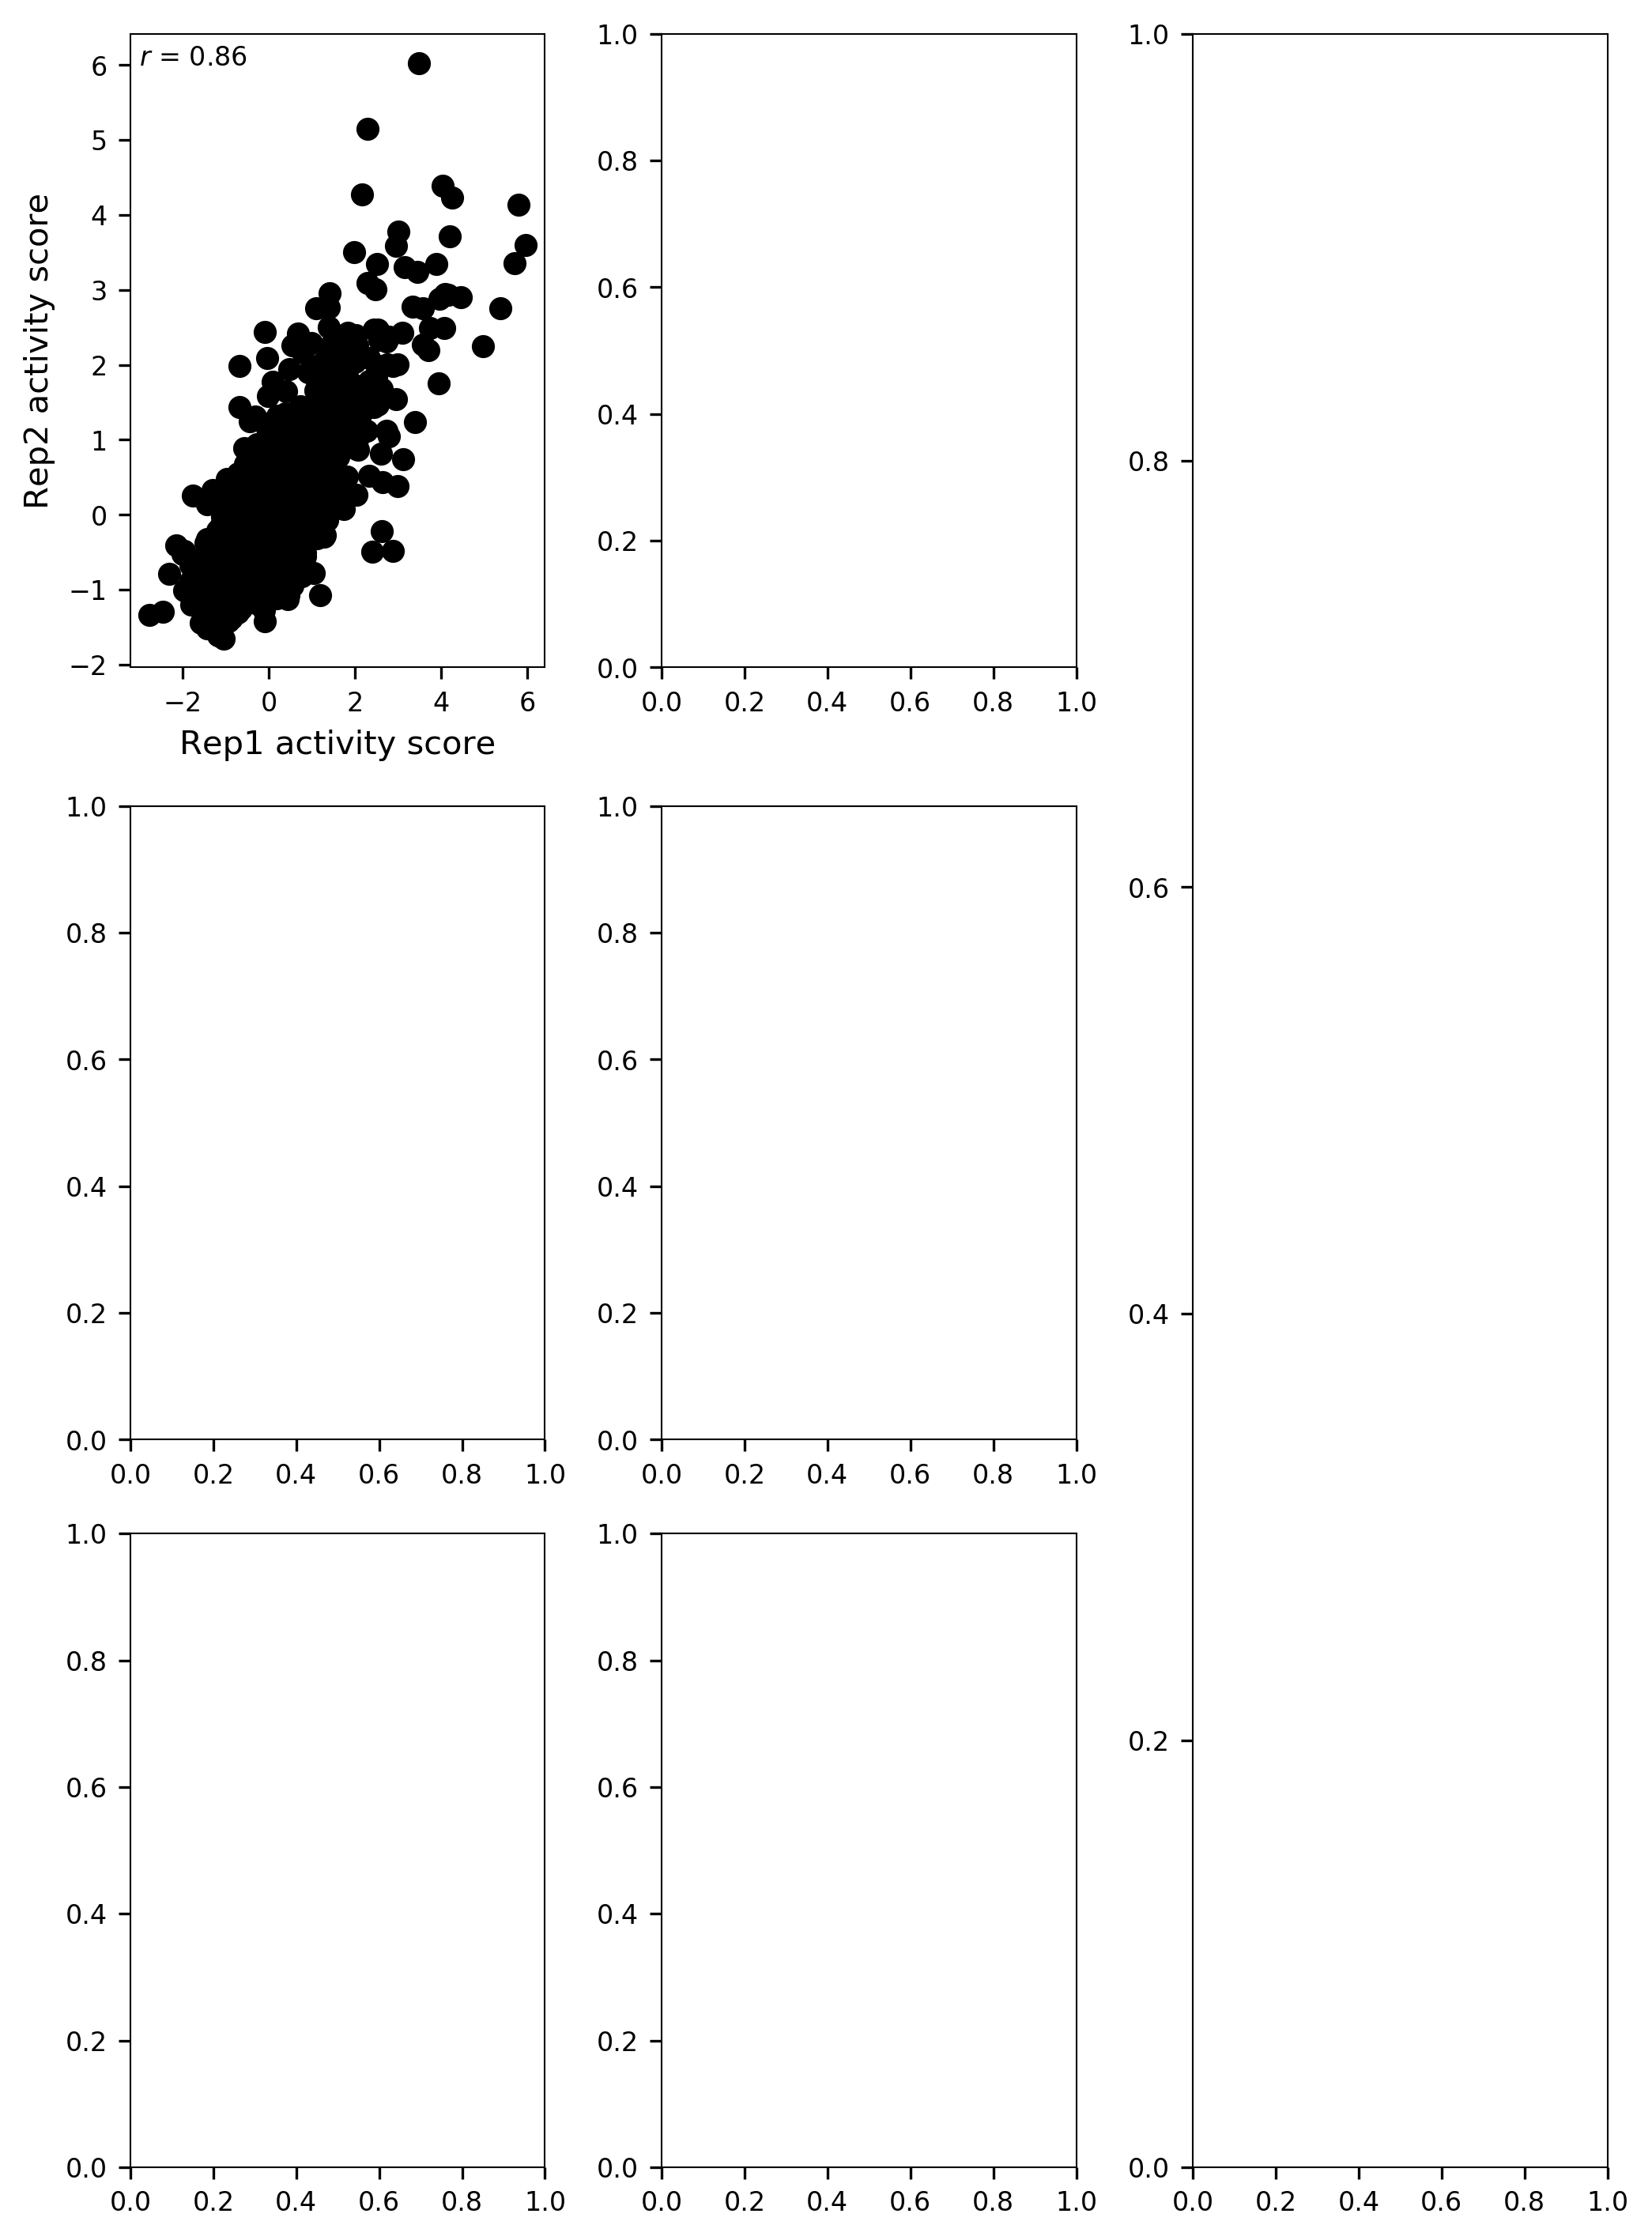

In [6]:
fig3

# B. Synonymous and nonsynonymous distributions

Text(702.9396325459318, 0.5, 'Density')

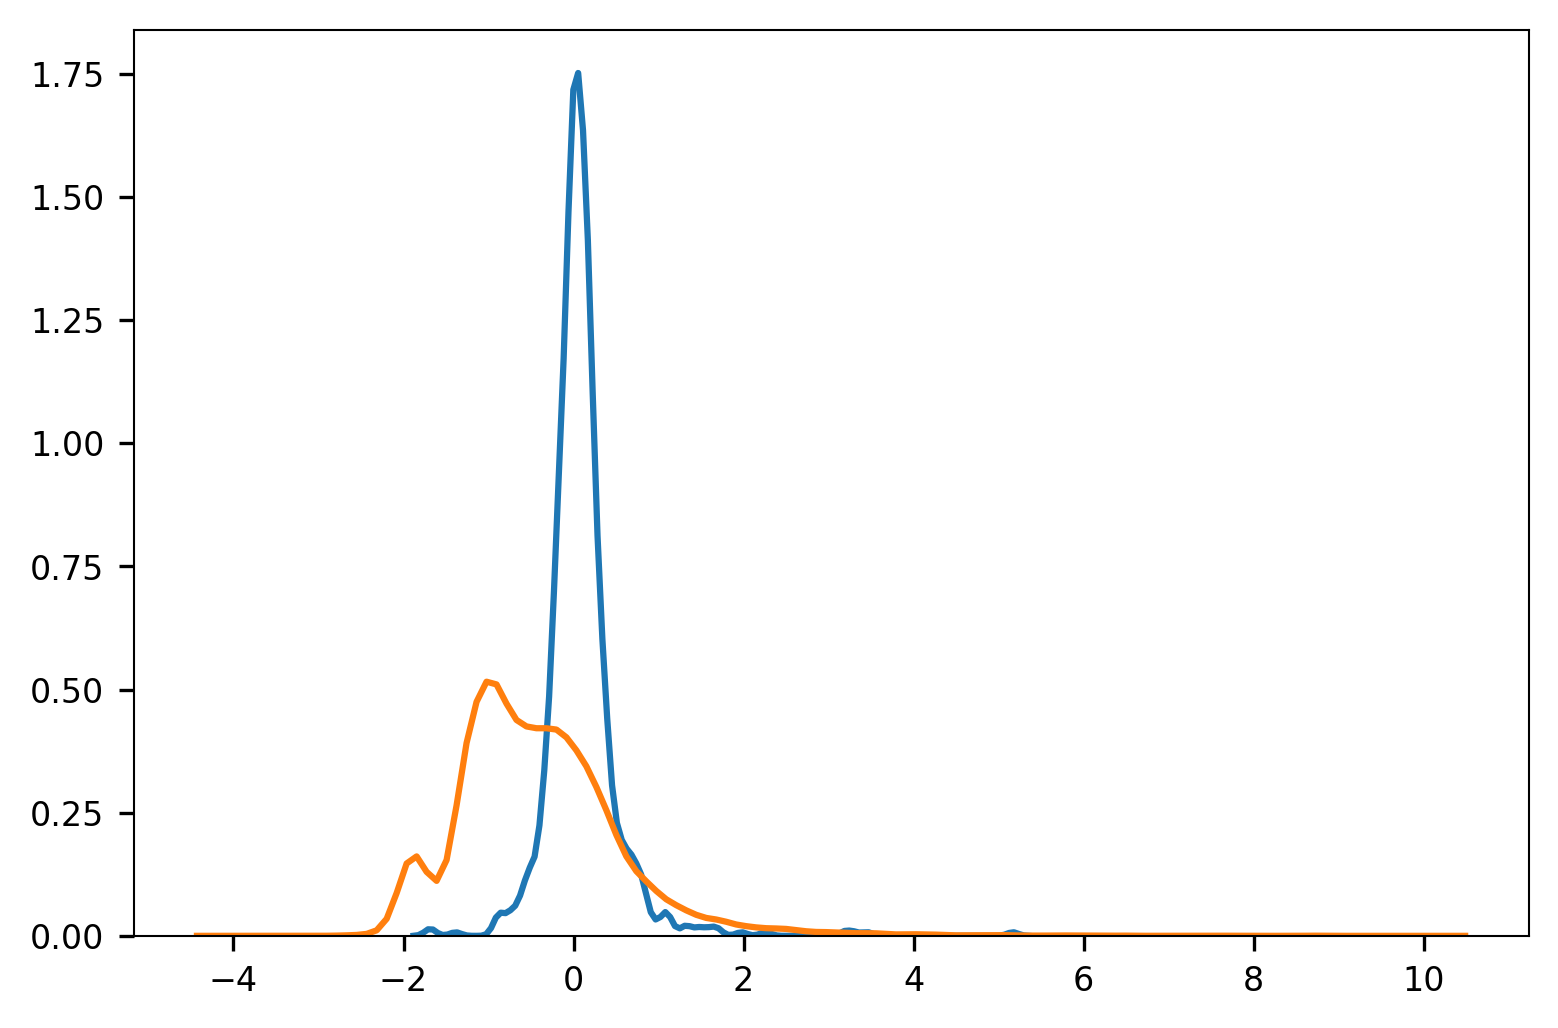

In [596]:
# Get nucleotide variants to differentiate synonymous and nonsynon
variants = raw_data.select('/main/variants/scores_shared')

# Separate into nonsyn and syn lists
synon = []
nonsynon = []
synon_names = []  # This was manually confirmed to be correct later
for variant in variants.index.tolist():
    if (variant.count('(p.=)') == variant.count('(p.')) or (variant == "_wt"):
        synon.append(variants.loc[variant].values[1::2])
        synon_names.append(variant)
    else:
        nonsynon.append(variants.loc[variant].values[1::2])
        
# Flip scores because of negative selection
synon = -1 * np.array(synon).flatten()
nonsynon = -1 * np.array(nonsynon).flatten()

# Use seaborn to get the density plot
synon_plot = sns.distplot(synon, hist=False)
nonsynon_plot = sns.distplot(nonsynon, hist=False)

# Get data from seaborn plots
synon_lines = synon_plot.get_lines()[0].get_data()
nonsynon_lines = nonsynon_plot.get_lines()[1].get_data()

# Plot lines
norm_syn = synon_lines[1] / max(synon_lines[1])
norm_nonsynon = nonsynon_lines[1] / max(nonsynon_lines[1])
f3_ax2.plot(synon_lines[0], norm_syn, c='k')
f3_ax2.plot(nonsynon_lines[0], norm_nonsynon, c='k')

# Plot limits
f3_ax2.set_xlim([-4, 5])
f3_ax2.set_ylim([0, 1.2])

# Fill under the curve
ns_color = 'lightgrey'
s_color = 'grey'
f3_ax2.fill_between(nonsynon_lines[0], 0, norm_nonsynon, color=ns_color)
f3_ax2.fill_between(synon_lines[0], 0, norm_syn, color=s_color)

# Custom legend
legend_elements = [
    matplotlib.patches.Patch(facecolor=ns_color, edgecolor='k',label='Nonsynonymous'),
    matplotlib.patches.Patch(facecolor=s_color, edgecolor='k',label='Synonymous')
                  ]
f3_ax2.legend(handles=legend_elements)

# Set axes labels
f3_ax2.set_xlabel('Radicicol activity score')
f3_ax2.set_ylabel('Density')

# C. residual fit

In [597]:
# Read in data
point_muts = pd.read_csv('../../utils/point_muts.csv', index_col=0, header=[0,1])
resids = pd.read_csv('../../utils/residuals.csv', index_col=0)['raw_resids'].values
rad_scores = point_muts.loc[:, ('Radicicol', 'score')].values
dmso_scores = point_muts.loc[:, ('Zero', 'score')].values

# Fit data
coef = np.polyfit(dmso_scores, rad_scores, 1)
poly1d_fn = np.poly1d(coef) 

# Normalize residual score
max_abs = np.nanmax(abs(resids))

# Plot on grid
f3_ax3.scatter(dmso_scores, rad_scores, c=resids, cmap='bwr', vmin=-max_abs, vmax=max_abs)
f3_ax3.plot(dmso_scores, poly1d_fn(dmso_scores), color='k')

# Get limits
min_x, max_x = f3_ax3.get_xlim()
min_y, max_y = f3_ax3.get_ylim()
f3_ax3.text(min_x + 0.5, max_y - 0.5, '$y={:.2f}x{:.2f}$'.format(coef[0], coef[1]))

# Set axes labels
f3_ax3.set_xlabel('Activity score')
f3_ax3.set_ylabel('Radicicol activity score')

Text(13.333333333333332, 0.5, 'Radicicol activity score')

# D. text explaining client score

In [598]:
f3_ax4.text(0, 0.8, 'client score = \n$activity_{rad}-E(activity_0)$')
f3_ax4.text(0, 0.5, 'client score > 0; \nHsp90 inhibited')
f3_ax4.text(0, 0.2, 'client score < 0; \nHsp90 dependent' )

f3_ax4.axis('off')

(0.0, 1.0, 0.0, 1.0)

# E. Appropriateness of linear fit and error of large residuals

In [599]:
se = point_muts.loc[:, ('Radicicol', 'SE')].values
f3_ax5.scatter(rad_scores, se, c='k', alpha=0.3)


# Set axes labels
f3_ax5.set_xlabel('Radicicol activity score')
f3_ax5.set_ylabel('Standard error')

Text(13.333333333333332, 0.5, 'Standard error')

# F. Histogram of client scores and coloring strong/weak/non clients

Text(702.9396325459318, 0.5, 'Density')

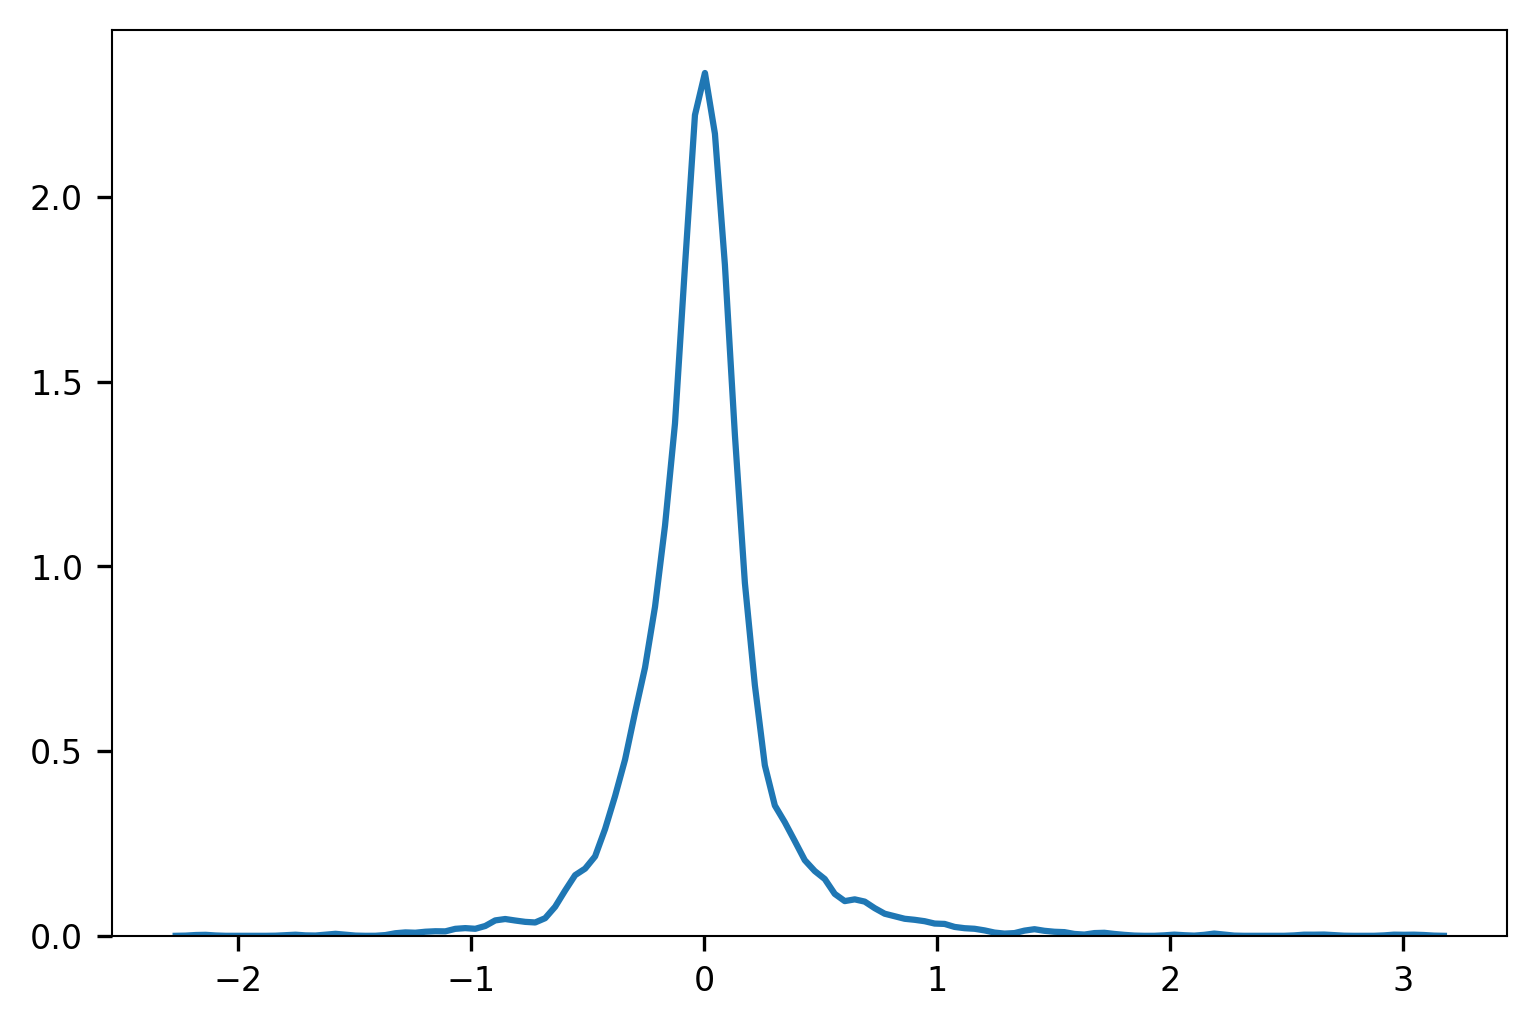

In [600]:
# Get seaborn distplot and plot myself
resid_dist = sns.distplot(resids, hist=False).get_lines()[0].get_data()

# Normalize top to 1
resid_dist_norm = resid_dist[1] / max(resid_dist[1])
f3_ax6.plot(resid_dist[0], resid_dist_norm, c='k')

# Set axes limits
f3_ax6.set_xlim([-2, 2])
f3_ax6.set_ylim([0, 1.3])

# Get std and mean to threshold
resid_std = np.nanstd(resids)
resid_mean = np.nanmean(resids)

# Get index of elements in x array that correspond to threshold values
def get_closest_element_index(arr, val):
    abs_arr = np.abs(arr - val)
    min_diff_idx = abs_arr.argmin()
    return(min_diff_idx)
nc_lower = get_closest_element_index(resid_dist[0], resid_mean - resid_std)
nc_upper = get_closest_element_index(resid_dist[0], resid_mean + resid_std)
dc2 = get_closest_element_index(resid_dist[0], resid_mean - 2 * resid_std)
ic2 = get_closest_element_index(resid_dist[0], resid_mean + 2 * resid_std)

# Get colors for different clients
cmap = matplotlib.cm.get_cmap('bwr')
nc_color = 'lightgrey'
dep1 = cmap(0.3)
ihb1 = cmap(0.8)

# Fill under the curve
f3_ax6.fill_between(x=resid_dist[0], y1=0, y2=resid_dist_norm, color=nc_color)
f3_ax6.fill_between(x=resid_dist[0][:nc_lower], y1=0, y2=resid_dist_norm[:nc_lower], color=dep1)
f3_ax6.fill_between(x=resid_dist[0][nc_upper:], y1=0, y2=resid_dist_norm[nc_upper:], color=ihb1)

# Custom legend
legend_elements = [
    matplotlib.patches.Patch(facecolor=nc_color, edgecolor='k',label='Nonclient'),
    matplotlib.patches.Patch(facecolor=dep1, edgecolor='k',label='Dependent client'),
    matplotlib.patches.Patch(facecolor=ihb1, edgecolor='k',label='Inhibited client')
                  ]
f3_ax6.legend(handles=legend_elements)

# Set axes labels
f3_ax6.set_xlabel('Client score')
f3_ax6.set_ylabel('Density')


# G: Heatmap

In [601]:
# Read in data
resid_heatmap = pd.read_csv('../heatmaps/raw_resid_heatmap.csv', index_col=0)

# Set syn values to 0.0
syn_mask = np.zeros((250, 21))
for pos, idx in zip(np.arange(250), wt_aa_x_idx):
    syn_mask[pos, int(idx)] = 1.
syn_mask = syn_mask.astype(bool)
resid_heatmap.values[syn_mask] = 0.

# Set colormap NaNs to gray
current_cmap = matplotlib.cm.get_cmap('bwr')
current_cmap.set_bad(color='lightgrey')

# Get WTaa index positions and plot dots
aa_seq = src_utils.__aa_seq__
wt_aa_x_idx = np.zeros(len(aa_seq))
for idx, aa in enumerate(aa_seq):
    wt_aa_x_idx[idx] = src_utils.__aa_idx_dict__[aa]

f3_ax7.imshow(resid_heatmap, cmap='bwr', vmin=-4, vmax=4)
f3_ax7.scatter(wt_aa_x_idx, np.arange(len(aa_seq)), s=0.5, marker='.', c='k')

# Set ticks
f3_ax7.set_xticks(np.arange(21))
f3_ax7.set_xticklabels(list(src_utils.__aa_idx_dict__.keys()), fontsize=3)
f3_ax7.set_yticks(list(src_utils.__pos_idx_dict__.values())[::5])
f3_ax7.set_yticklabels(list(src_utils.__pos_idx_dict__.keys())[::5])


[Text(0, 0.0, '270'),
 Text(0, 0.2, '275'),
 Text(0, 0.4, '280'),
 Text(0, 0.6000000000000001, '285'),
 Text(0, 0.8, '290'),
 Text(0, 1.0, '295'),
 Text(0, 0, '300'),
 Text(0, 0, '305'),
 Text(0, 0, '310'),
 Text(0, 0, '315'),
 Text(0, 0, '320'),
 Text(0, 0, '325'),
 Text(0, 0, '330'),
 Text(0, 0, '335'),
 Text(0, 0, '340'),
 Text(0, 0, '345'),
 Text(0, 0, '350'),
 Text(0, 0, '355'),
 Text(0, 0, '360'),
 Text(0, 0, '365'),
 Text(0, 0, '370'),
 Text(0, 0, '375'),
 Text(0, 0, '380'),
 Text(0, 0, '385'),
 Text(0, 0, '390'),
 Text(0, 0, '395'),
 Text(0, 0, '400'),
 Text(0, 0, '405'),
 Text(0, 0, '410'),
 Text(0, 0, '415'),
 Text(0, 0, '420'),
 Text(0, 0, '425'),
 Text(0, 0, '430'),
 Text(0, 0, '435'),
 Text(0, 0, '440'),
 Text(0, 0, '445'),
 Text(0, 0, '450'),
 Text(0, 0, '455'),
 Text(0, 0, '460'),
 Text(0, 0, '465'),
 Text(0, 0, '470'),
 Text(0, 0, '475'),
 Text(0, 0, '480'),
 Text(0, 0, '485'),
 Text(0, 0, '490'),
 Text(0, 0, '495'),
 Text(0, 0, '500'),
 Text(0, 0, '505'),
 Text(0, 0, '

In [604]:
for ax in [f3_ax1, f3_ax2, f3_ax3, f3_ax5, f3_ax6]:
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

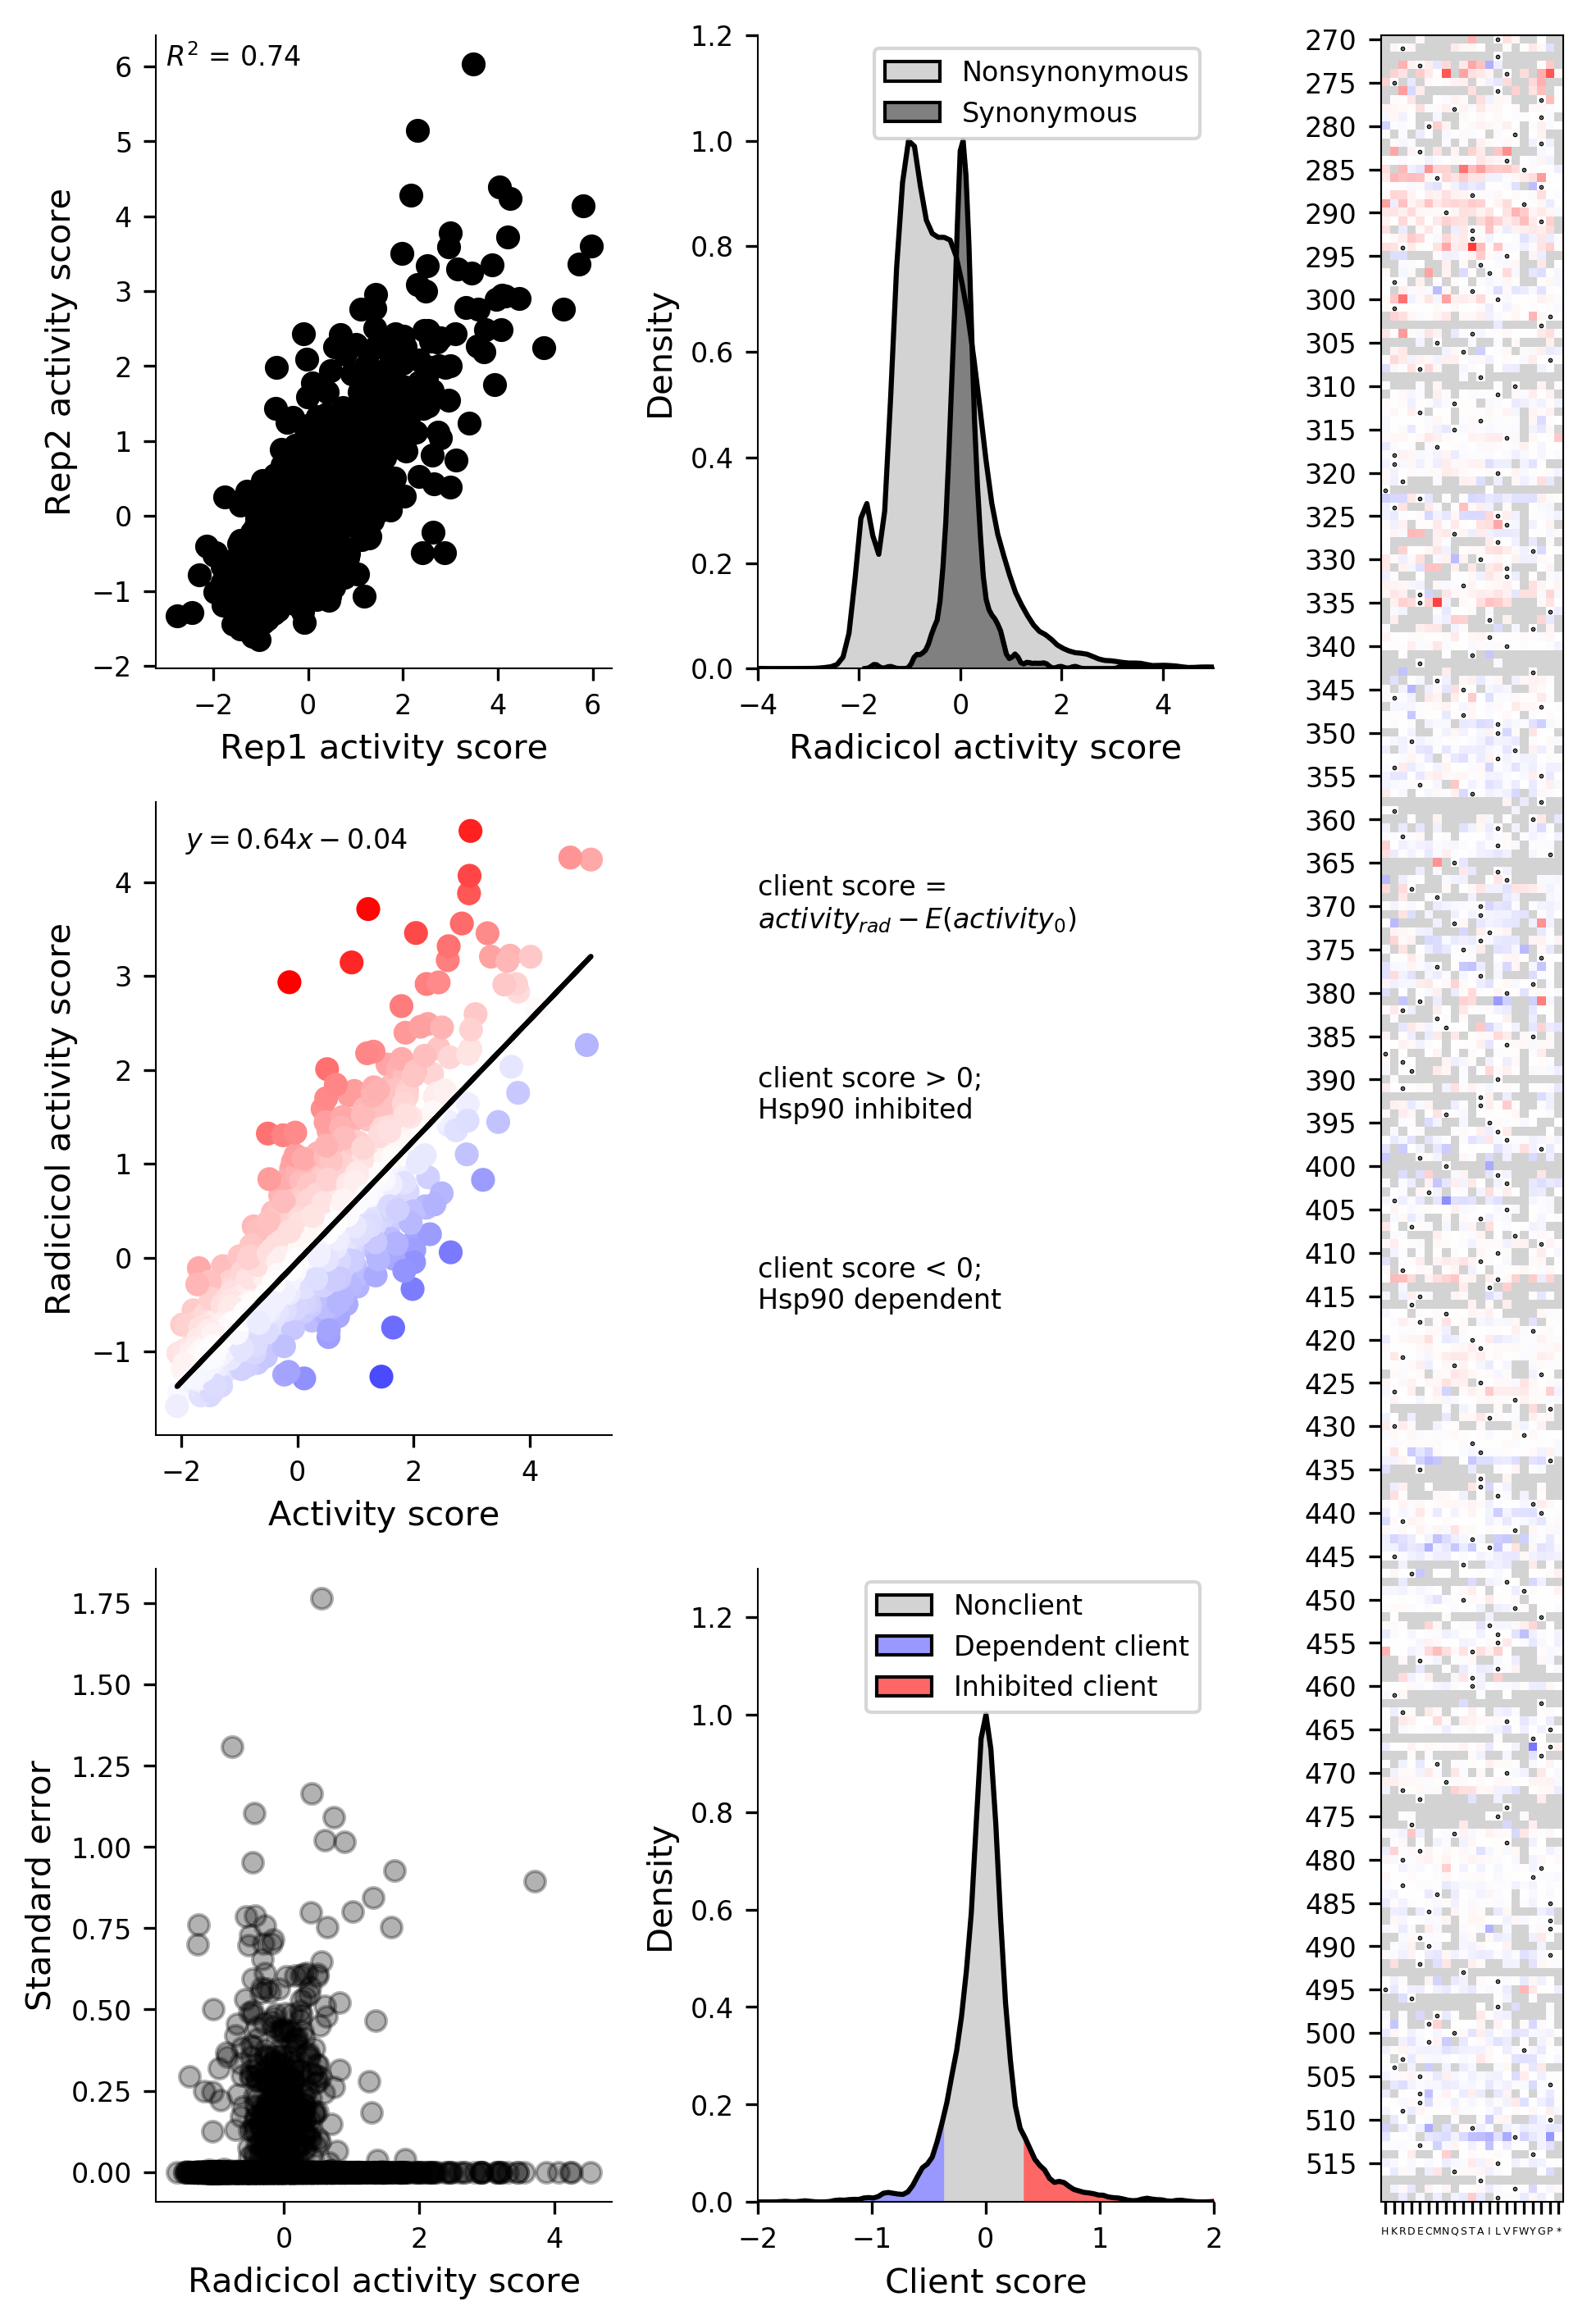

In [605]:
fig3

In [606]:
fig3.savefig('fig2_v1.png')